---
## 📦 Step 1: Data Loading and Cleaning
---


In this step, we load the dataset and remove any irrelevant or duplicate data.
We rename columns for clarity and encode categorical values to numerical format
(e.g., 'ham' and 'spam' to 0 and 1). This sets the foundation for further analysis.



In [4]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/My Drive/spamDetection/spam.csv"

# Load dataset
# The encoding parameter is added to specify the correct encoding for the CSV file.
# 'latin1' is a common encoding, but you may need to try others if it doesn't work.
df = pd.read_csv(dataset_path, encoding='latin1')
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

# Encode target labels
# Assuming LabelEncoder is imported
from sklearn.preprocessing import LabelEncoder
df['target'] = pd.Series(LabelEncoder().fit_transform(df['target']))

# Remove duplicates
df.drop_duplicates(inplace=True)

# Check shape after cleaning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 📊 Step 2: Exploratory Data Analysis (EDA)
---

We explore the dataset visually and statistically to understand the distribution of messages, their length, word counts, and sentence structure. This helps identify differences between spam and ham messages and uncover potential features for modeling.


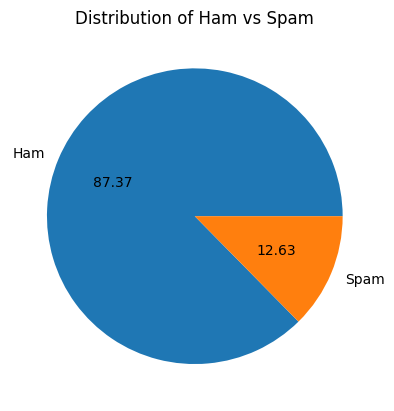

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


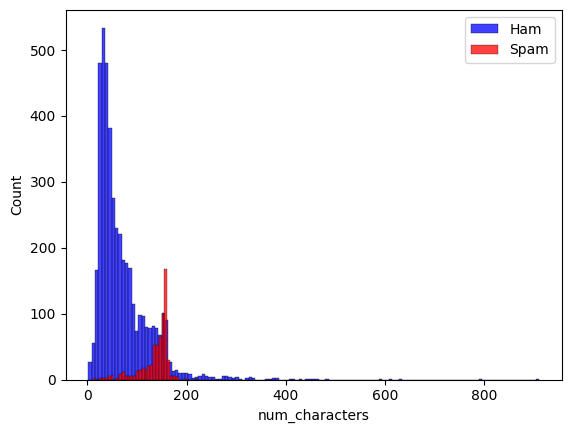

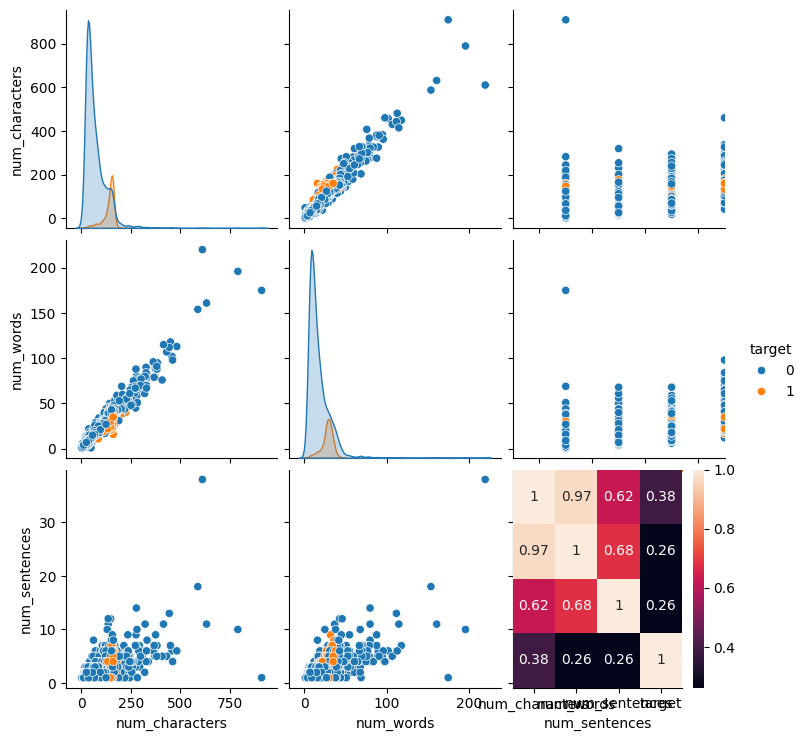

In [7]:
# Visualizing target distribution
plt.pie(df['target'].value_counts(), labels=['Ham', 'Spam'], autopct="%0.2f")
plt.title("Distribution of Ham vs Spam")
plt.show()

# Basic NLP stats
nltk.download('punkt')
nltk.download('punkt_tab')
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Visualization
sns.histplot(df[df['target'] == 0]['num_characters'], label='Ham', color='blue')
sns.histplot(df[df['target'] == 1]['num_characters'], label='Spam', color='red')
plt.legend()
plt.show()

sns.pairplot(df[['num_characters','num_words','num_sentences','target']], hue='target')
# Calculate correlation only for numerical features
numerical_features = ['num_characters', 'num_words', 'num_sentences', 'target']
sns.heatmap(df[numerical_features].corr(), annot=True)
plt.show()

---
## 🧹 Step 3: Text Preprocessing
---


Raw text data is messy and needs cleaning. Here, we lowercase the text, remove punctuation, stop words, and special characters, and apply stemming. This step converts the messages into a cleaner and more uniform format suitable for machine learning.



In [8]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

nltk.download('stopwords')
nltk.download('punkt')
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]
    text = [ps.stem(word) for word in text]
    return " ".join(text)

df['transformed_text'] = df['text'].apply(transform_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---
## ☁️ Step 4: WordCloud and Frequency Analysis
---


We transform the cleaned text into numerical features using the TF-IDF technique. This vectorized representation is then used to train a classification model that can distinguish between spam and ham messages.


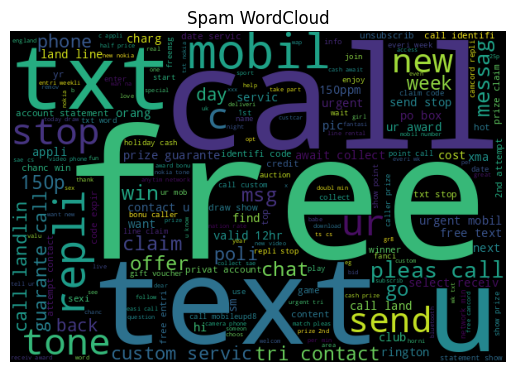

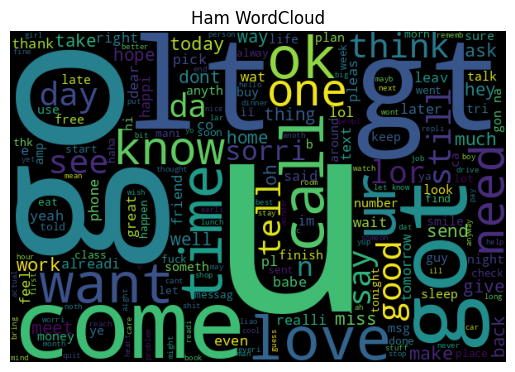

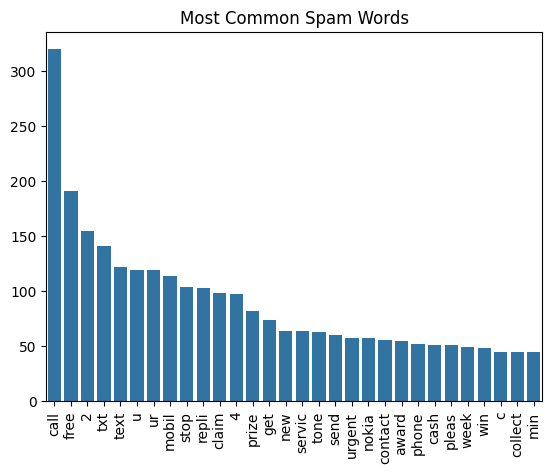

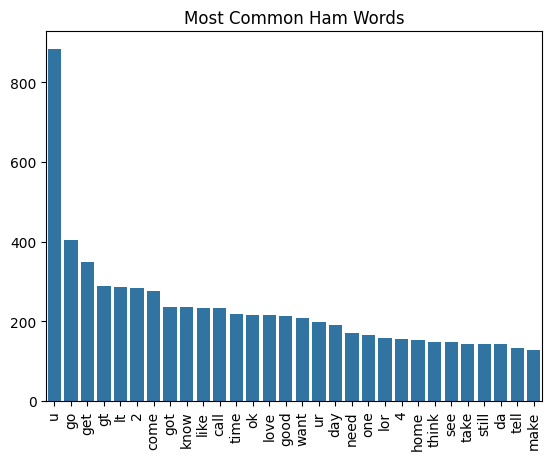

In [12]:
from wordcloud import WordCloud
from collections import Counter

spam_wc = WordCloud(width=600, height=400).generate(" ".join(df[df['target']==1]['transformed_text']))
plt.imshow(spam_wc)
plt.axis('off')
plt.title("Spam WordCloud")
plt.show()

ham_wc = WordCloud(width=600, height=400).generate(" ".join(df[df['target']==0]['transformed_text']))
plt.imshow(ham_wc)
plt.axis('off')
plt.title("Ham WordCloud")
plt.show()

# Word frequency bar plots
spam_words = sum([msg.split() for msg in df[df['target']==1]['transformed_text']], [])
ham_words = sum([msg.split() for msg in df[df['target']==0]['transformed_text']], [])

# Get the most common words and their counts
spam_word_counts = Counter(spam_words).most_common(30)
# Unpack words and counts into separate lists
spam_words, spam_counts = zip(*spam_word_counts)

# Use x and y keywords to specify the data for the barplot
sns.barplot(x=spam_words, y=spam_counts)
plt.xticks(rotation='vertical')
plt.title("Most Common Spam Words")
plt.show()

# Repeat for ham words
ham_word_counts = Counter(ham_words).most_common(30)
ham_words, ham_counts = zip(*ham_word_counts)
sns.barplot(x=ham_words, y=ham_counts)
plt.xticks(rotation='vertical')
plt.title("Most Common Ham Words")
plt.show()

---
## 🧠 Step 5: Model Building
---

After training, we test our model on unseen data to evaluate its performance. We calculate metrics like accuracy, precision, and visualize the confusion matrix to understand how well the model distinguishes spam from ham.



In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

---
## 🔍 Step 6: Model Evaluation
---

Based on the evaluation results, we may try different algorithms (like Naive Bayes, Logistic Regression, etc.), tune parameters, or use more features to improve the model’s performance.


SVC - Accuracy: 0.9758, Precision: 0.9748
NB - Accuracy: 0.9710, Precision: 1.0000
RF - Accuracy: 0.9739, Precision: 0.9826
AdaBoost - Accuracy: 0.9217, Precision: 0.8202
GBDT - Accuracy: 0.9507, Precision: 0.9307
LR - Accuracy: 0.9555, Precision: 0.9600


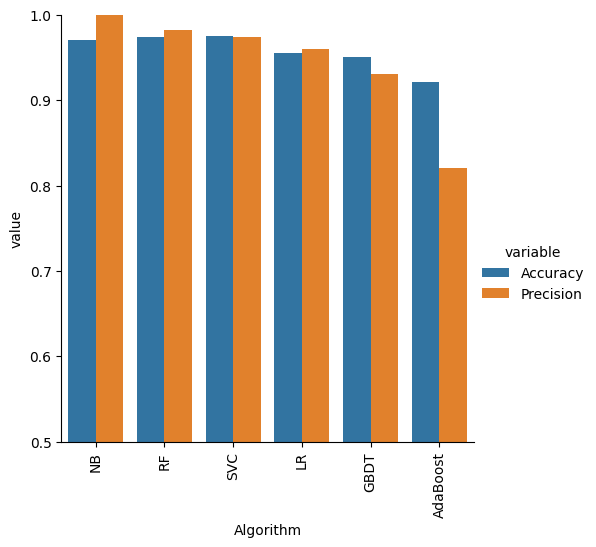

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Classifiers
clfs = {
    'SVC': SVC(kernel='sigmoid', gamma=1.0),
    'NB': MultinomialNB(),
    'RF': RandomForestClassifier(n_estimators=50, random_state=2),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=2),
    'GBDT': GradientBoostingClassifier(n_estimators=50, random_state=2),
    'LR': LogisticRegression(solver='liblinear', penalty='l1')
}

accuracy_scores, precision_scores = [], []

for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}")

performance_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores
}).sort_values('Precision', ascending=False)

sns.catplot(x='Algorithm', y='value', hue='variable', data=pd.melt(performance_df, id_vars='Algorithm'), kind='bar', height=5)
plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()

---
## 🤝 Step 7: Ensemble Learning (Voting & Stacking)
---

Once the model is ready, we prepare to integrate it into a web interface. This allows users to input a message and instantly check whether it's spam or not through a simple UI.



In [16]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Update SVC initialization with probability=True
clfs['SVC'] = SVC(kernel='sigmoid', gamma=1.0, probability=True)

voting_clf = VotingClassifier(estimators=[
    ('svc', clfs['SVC']),
    ('nb', clfs['NB']),
    ('rf', clfs['RF'])
], voting='soft')

voting_clf.fit(X_train, y_train)
print("Voting - Accuracy:", accuracy_score(y_test, voting_clf.predict(X_test)))
print("Voting - Precision:", precision_score(y_test, voting_clf.predict(X_test)))

stacking_clf = StackingClassifier(estimators=[
    ('svc', clfs['SVC']),
    ('nb', clfs['NB']),
    ('rf', clfs['RF'])
], final_estimator=LogisticRegression())

stacking_clf.fit(X_train, y_train)
print("Stacking - Accuracy:", accuracy_score(y_test, stacking_clf.predict(X_test)))
print("Stacking - Precision:", precision_score(y_test, stacking_clf.predict(X_test)))

Voting - Accuracy: 0.9777562862669246
Voting - Precision: 0.9914529914529915
Stacking - Accuracy: 0.9825918762088974
Stacking - Precision: 0.96875


---
## 💾 Step 8: Save Model and Vectorizer
---


In the final step, we deploy the model as a web service using a backend like Flask. This makes it accessible for real-world use, where users can interact with the model via an app or website.





In [17]:
import pickle

pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(clfs['NB'], open('model.pkl', 'wb'))